In [33]:
# Importando as Bibliotecas Necessárias
import pandas as pd
import numpy as np
from imblearn.under_sampling import ClusterCentroids, NearMiss
from collections import Counter
from sklearn.neighbors import LocalOutlierFactor
from imblearn.combine import SMOTEENN

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Validação e métricas
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Bibliotecas adicionais
import optuna
from optuna.integration.mlflow import MLflowCallback
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [34]:
# Configurando o MLflow
mlflow.set_experiment("Modelagem de Classificação")

<Experiment: artifact_location='file:///c:/Users/PC/Documents/GitHub/diabetes/mlruns/490920415060799094', creation_time=1732409763939, experiment_id='490920415060799094', last_update_time=1732409763939, lifecycle_stage='active', name='Modelagem de Classificação', tags={}>

In [ ]:
# Carregando os conjuntos de dados
train_data = pd.read_csv('C:\\Users\\PC\\Downloads\\dataset\\train_data.csv')
validation_data = pd.read_csv('C:\\Users\\PC\\Downloads\\dataset\\validation_data.csv')
test_data = pd.read_csv('C:\\Users\\PC\\Downloads\\dataset\\test_data.csv')

In [36]:
# Separando features e target no conjunto de treinamento
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

# Separando features e target no conjunto de validação
X_val = validation_data.drop('class', axis=1)
y_val = validation_data['class']


In [37]:
print('Distribuição das classes no conjunto de treinamento antes do under-sampling:')
print(Counter(y_train))


Distribuição das classes no conjunto de treinamento antes do under-sampling:
Counter({0: 72323, 1: 9085})


In [ ]:
# Criando o ClusterCentroids
cc = ClusterCentroids(random_state=42)

# Aplicando o under-sampling
X_train, y_train = cc.fit_resample(X_train, y_train)

print('Distribuição das classes após o Cluster Centroids:')
print(Counter(y_train))


Distribuição das classes após o Cluster Centroids:
Counter({0: 9085, 1: 9085})


In [40]:
# Definindo uma Função de Avaliação
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Treinando e avaliando o modelo com os dados originais
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_true = y_val
    X_val_used = X_val

    # Calculando as métricas
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val_used)
        if y_prob.ndim == 1 or y_prob.shape[1] == 2:
            y_prob = y_prob[:, -1]  # Para classes binárias
            roc_auc = roc_auc_score(y_true, y_prob)
        else:
            roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovo', average='weighted')
    else:
        roc_auc = None
    return acc, f1, recall, roc_auc


In [41]:
# Definindo os Modelos
models = {
    'K-NN': KNeighborsClassifier(),
    'LVQ': NearestCentroid(),
    'Árvore de Decisão': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Rede Neural MLP': MLPClassifier(max_iter=500),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

In [42]:
# Comitê de Redes Neurais Artificiais
# Definindo múltiplas redes neurais
nn1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=1)
nn2 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='sgd', max_iter=500, random_state=2)
nn3 = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=3)

# Criando o Comitê
committee_nn = VotingClassifier(estimators=[
    ('nn1', nn1),
    ('nn2', nn2),
    ('nn3', nn3)
], voting='soft')

models['Comitê de Redes Neurais Artificiais'] = committee_nn


In [43]:
# Comitê Heterogêneo (Stacking)
# Modelos base
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Modelo meta
from sklearn.linear_model import LogisticRegression
final_estimator = LogisticRegression()

# Criando o StackingClassifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

models['Comitê Heterogêneo (Stacking)'] = stacking_model

In [44]:
# Executando os Modelos Básicos e Registrando no MLflow
initial_results = []

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        acc, f1, recall, roc_auc = evaluate_model(model, X_train, y_train, X_val, y_val, model_name)
        mlflow.log_param("model_type", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", recall)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        # Salvar o modelo
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} - Acurácia: {acc}, F1-Score: {f1}, Recall: {recall}, ROC AUC: {roc_auc}")
        initial_results.append({
            'Modelo': model_name,
            'Acurácia': acc,
            'F1-Score': f1,
            'Recall': recall,
            'ROC AUC': roc_auc
        })

# Converte os resultados iniciais em DataFrame
initial_results_df = pd.DataFrame(initial_results)

# Exibindo os resultados iniciais
print(initial_results_df)

2024/11/26 16:43:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-NN - Acurácia: 0.6068796068796068, F1-Score: 0.6789590861818335, Recall: 0.6068796068796068, ROC AUC: 0.5242257630860948


2024/11/26 16:43:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LVQ - Acurácia: 0.2813759213759214, F1-Score: 0.3338918735922431, Recall: 0.2813759213759214, ROC AUC: None


2024/11/26 16:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Árvore de Decisão - Acurácia: 0.1945945945945946, F1-Score: 0.19434854791904418, Recall: 0.1945945945945946, ROC AUC: 0.49127178159119556


2024/11/26 16:44:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM - Acurácia: 0.3207862407862408, F1-Score: 0.3901020927000174, Recall: 0.32078624078624074, ROC AUC: None


2024/11/26 16:44:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acurácia: 0.13690417690417692, F1-Score: 0.07858084605449771, Recall: 0.13690417690417692, ROC AUC: 0.4830924853802537


2024/11/26 16:44:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Rede Neural MLP - Acurácia: 0.15056511056511057, F1-Score: 0.10537527432810576, Recall: 0.15056511056511057, ROC AUC: 0.4679633559738785


2024/11/26 16:44:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acurácia: 0.14368550368550367, F1-Score: 0.09348308780724147, Recall: 0.14368550368550367, ROC AUC: 0.4821135992857243
[LightGBM] [Info] Number of positive: 9085, number of negative: 9085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4628
[LightGBM] [Info] Number of data points in the train set: 18170, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/11/26 16:44:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - Acurácia: 0.1377886977886978, F1-Score: 0.07928348355681411, Recall: 0.1377886977886978, ROC AUC: 0.4902632411350501


2024/11/26 16:45:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê de Redes Neurais Artificiais - Acurácia: 0.16294840294840296, F1-Score: 0.12933136873054843, Recall: 0.16294840294840296, ROC AUC: 0.501734658420709


2024/11/26 16:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê Heterogêneo (Stacking) - Acurácia: 0.15577395577395578, F1-Score: 0.11738161287089525, Recall: 0.15577395577395578, ROC AUC: 0.48330522742606763
                                Modelo  Acurácia  F1-Score    Recall   ROC AUC
0                                 K-NN  0.606880  0.678959  0.606880  0.524226
1                                  LVQ  0.281376  0.333892  0.281376       NaN
2                    Árvore de Decisão  0.194595  0.194349  0.194595  0.491272
3                                  SVM  0.320786  0.390102  0.320786       NaN
4                        Random Forest  0.136904  0.078581  0.136904  0.483092
5                      Rede Neural MLP  0.150565  0.105375  0.150565  0.467963
6                              XGBoost  0.143686  0.093483  0.143686  0.482114
7                             LightGBM  0.137789  0.079283  0.137789  0.490263
8  Comitê de Redes Neurais Artificiais  0.162948  0.129331  0.162948  0.501735
9        Comitê Heterogêneo (Stacking)  0.155774  0.117382

In [45]:
# Busca de Hiperparâmetros com Optuna
# Configurando o Callback do MLflow para o Optuna
mlflc = MLflowCallback(tracking_uri=mlflow.get_tracking_uri(), metric_name='accuracy')


In [46]:
def build_classifier(model_name, params):
    if model_name == 'K-NN':
        classifier = KNeighborsClassifier(
            n_neighbors=params['n_neighbors'],
            weights=params['weights'],
            algorithm=params['algorithm']
        )
    elif model_name == 'LVQ':
        classifier = NearestCentroid(
            metric=params['metric'],
            shrink_threshold=params['shrink_threshold']
        )
    elif model_name == 'Árvore de Decisão':
        classifier = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            criterion=params['criterion']
        )
    elif model_name == 'SVM':
        classifier = SVC(
            C=params['C'],
            kernel=params['kernel'],
            gamma=params['gamma']
        )
    elif model_name == 'Random Forest':
        classifier = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split']
        )
    elif model_name == 'Rede Neural MLP':
        classifier = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            alpha=params['alpha'],
            max_iter=500
        )
    elif model_name == 'Comitê de Redes Neurais Artificiais':
        nn1 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=1
        )
        nn2 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=2
        )
        nn3 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=3
        )
        classifier = VotingClassifier(
            estimators=[
                ('nn1', nn1),
                ('nn2', nn2),
                ('nn3', nn3)
            ],
            voting='soft'
        )
    elif model_name == 'Comitê Heterogêneo (Stacking)':
        final_estimator = LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver=params['solver']
        )
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(random_state=42)),
            ('knn', KNeighborsClassifier())
        ]
        classifier = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5
        )
    elif model_name == 'XGBoost':
        classifier = XGBClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            use_label_encoder=False,
            eval_metric='logloss'
        )
    elif model_name == 'LightGBM':
        classifier = LGBMClassifier(
            n_estimators=params['n_estimators'],
            num_leaves=params['num_leaves'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample']
        )
    else:
        raise ValueError(f"Modelo {model_name} não reconhecido.")
    return classifier


In [47]:
def objective_factory(model_name):
    def objective(trial):
        params = {}
        # Definir os hiperparâmetros para cada modelo
        if model_name == 'K-NN':
            params['n_neighbors'] = trial.suggest_int('n_neighbors', 1, 30)
            params['weights'] = trial.suggest_categorical('weights', ['uniform', 'distance'])
            params['algorithm'] = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        
        elif model_name == 'LVQ':
            params['metric'] = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
            use_shrinkage = trial.suggest_categorical('use_shrinkage', [True, False])
            params['shrink_threshold'] = trial.suggest_float('shrink_threshold', 0.0, 1.0) if use_shrinkage else None
        
        elif model_name == 'Árvore de Decisão':
            params['max_depth'] = trial.suggest_int('max_depth', 1, 20)
            params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
            params['criterion'] = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        
        elif model_name == 'SVM':
            params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
            params['kernel'] = trial.suggest_categorical('kernel', ['linear', 'rbf'])
            params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
        
        elif model_name == 'Random Forest':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['max_depth'] = trial.suggest_int('max_depth', 2, 20)
            params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
        
        elif model_name == 'Rede Neural MLP':
            params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
            params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
            params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
            params['alpha'] = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
        
        elif model_name == 'Comitê de Redes Neurais Artificiais':
            params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
            params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
            params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
        
        elif model_name == 'Comitê Heterogêneo (Stacking)':
            params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
            params['penalty'] = trial.suggest_categorical('penalty', ['l2'])
            params['solver'] = trial.suggest_categorical('solver', ['lbfgs'])
        
        elif model_name == 'XGBoost':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['max_depth'] = trial.suggest_int('max_depth', 3, 15)
            params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        elif model_name == 'LightGBM':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['num_leaves'] = trial.suggest_int('num_leaves', 31, 150)
            params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        else:
            raise ValueError(f"Modelo {model_name} não reconhecido.")
        
        classifier = build_classifier(model_name, params)
        
        acc = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean()
        return acc
    return objective


In [48]:
# Executando as Otimizações com Optuna
n_trials = 5  # Número de iterações

In [49]:
# Dicionário para armazenar os melhores modelos e seus scores
best_models = {}
best_params = {}
cv_results = {}


In [50]:
for model_name in models.keys():
    print(f"Otimização para o modelo: {model_name}")
    study = optuna.create_study(direction='maximize', study_name='Modelagem', sampler=optuna.samplers.TPESampler(seed=124))
    study.optimize(objective_factory(model_name), n_trials=n_trials, callbacks=[mlflc])
    
    # Armazenando os melhores hiperparâmetros
    best_params[model_name] = study.best_params
    
    # Criando o classificador com os melhores hiperparâmetros
    classifier = build_classifier(model_name, best_params[model_name])
    
    # Armazenando o classificador
    best_models[model_name] = classifier
    
    # Armazenando os scores dos folds
    acc_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[model_name] = acc_scores


[I 2024-11-26 16:47:14,603] A new study created in memory with name: Modelagem


Otimização para o modelo: K-NN


[I 2024-11-26 16:47:17,021] Trial 0 finished with value: 0.6334067143643368 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 0 with value: 0.6334067143643368.
[I 2024-11-26 16:47:18,782] Trial 1 finished with value: 0.667749036873968 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.667749036873968.
[I 2024-11-26 16:47:21,871] Trial 2 finished with value: 0.6524490919097413 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.667749036873968.
[I 2024-11-26 16:47:22,853] Trial 3 finished with value: 0.6367088607594936 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 1 with value: 0.667749036873968.
[I 2024-11-26 16:47:25,923] Trial 4 finished with value: 0.6407264722069346 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 1 with val

Otimização para o modelo: LVQ


[I 2024-11-26 16:47:27,560] Trial 0 finished with value: 0.7383599339570721 and parameters: {'metric': 'manhattan', 'use_shrinkage': True, 'shrink_threshold': 0.3847059030441362}. Best is trial 0 with value: 0.7383599339570721.
[I 2024-11-26 16:47:28,274] Trial 1 finished with value: 0.7376995046780408 and parameters: {'metric': 'manhattan', 'use_shrinkage': True, 'shrink_threshold': 0.7799197053505602}. Best is trial 0 with value: 0.7383599339570721.
[I 2024-11-26 16:47:28,946] Trial 2 finished with value: 0.5516235553109521 and parameters: {'metric': 'euclidean', 'use_shrinkage': False}. Best is trial 0 with value: 0.7383599339570721.
[I 2024-11-26 16:47:29,601] Trial 3 finished with value: 0.5516235553109521 and parameters: {'metric': 'euclidean', 'use_shrinkage': False}. Best is trial 0 with value: 0.7383599339570721.
[I 2024-11-26 16:47:30,301] Trial 4 finished with value: 0.7380297193175565 and parameters: {'metric': 'manhattan', 'use_shrinkage': True, 'shrink_threshold': 0.55551

Otimização para o modelo: Árvore de Decisão


[I 2024-11-26 16:47:31,944] Trial 0 finished with value: 0.7904788112272978 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.7904788112272978.
[I 2024-11-26 16:47:32,693] Trial 1 finished with value: 0.8708860759493671 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.8708860759493671.
[I 2024-11-26 16:47:33,424] Trial 2 finished with value: 0.8489268024215739 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.8708860759493671.
[I 2024-11-26 16:47:34,209] Trial 3 finished with value: 0.8707209686296092 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.8708860759493671.
[I 2024-11-26 16:47:34,865] Trial 4 finished with value: 0.706274078150798 and parameters: {'max_depth': 1, 'min_samples_split': 8, 'criterion': 'entropy'}. Best is trial 1 with value: 0.

Otimização para o modelo: SVM


[I 2024-11-26 16:47:51,824] Trial 0 finished with value: 0.9408915795266923 and parameters: {'C': 0.1629783106849361, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.9408915795266923.
[I 2024-11-26 16:48:09,803] Trial 1 finished with value: 0.9417171161254816 and parameters: {'C': 0.3531657771747683, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.9417171161254816.
[I 2024-11-26 16:48:50,830] Trial 2 finished with value: 0.851073197578426 and parameters: {'C': 1.5782955339861555, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.9417171161254816.
[I 2024-11-26 16:49:31,742] Trial 3 finished with value: 0.8821684094661529 and parameters: {'C': 0.19069654088974608, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.9417171161254816.
[I 2024-11-26 16:50:24,610] Trial 4 finished with value: 0.860759493670886 and parameters: {'C': 1.7590040052184819, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.94171

Otimização para o modelo: Random Forest


[I 2024-11-26 16:51:29,284] Trial 0 finished with value: 0.9231150247660981 and parameters: {'n_estimators': 76, 'max_depth': 16, 'min_samples_split': 7}. Best is trial 0 with value: 0.9231150247660981.
[I 2024-11-26 16:51:32,321] Trial 1 finished with value: 0.9114474408365437 and parameters: {'n_estimators': 165, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.9231150247660981.
[I 2024-11-26 16:51:36,094] Trial 2 finished with value: 0.9129334067143644 and parameters: {'n_estimators': 217, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.9231150247660981.
[I 2024-11-26 16:51:41,639] Trial 3 finished with value: 0.9210236653824986 and parameters: {'n_estimators': 245, 'max_depth': 13, 'min_samples_split': 3}. Best is trial 0 with value: 0.9231150247660981.
[I 2024-11-26 16:51:45,804] Trial 4 finished with value: 0.9230599889928455 and parameters: {'n_estimators': 147, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 0 with value: 0.9

Otimização para o modelo: Rede Neural MLP


[I 2024-11-26 16:52:28,355] Trial 0 finished with value: 0.9357732526141993 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.000381856372967541}. Best is trial 0 with value: 0.9357732526141993.
[I 2024-11-26 16:52:35,781] Trial 1 finished with value: 0.8284534947716015 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 3.636517070731461e-05}. Best is trial 0 with value: 0.9357732526141993.
[I 2024-11-26 16:53:05,414] Trial 2 finished with value: 0.9341221794166208 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00041681748648122335}. Best is trial 0 with value: 0.9357732526141993.
[I 2024-11-26 16:53:14,038] Trial 3 finished with value: 0.8473858007705009 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 2.4452146742068298e-05}. Best is trial 0 with value: 0.9357732526141993.
[I 2024-11-26 16:53:30,98

Otimização para o modelo: XGBoost


[I 2024-11-26 16:55:52,351] Trial 0 finished with value: 0.9390203632361034 and parameters: {'n_estimators': 76, 'max_depth': 12, 'learning_rate': 0.0700448951165749, 'subsample': 0.7291205918804406}. Best is trial 0 with value: 0.9390203632361034.
[I 2024-11-26 16:55:54,325] Trial 1 finished with value: 0.9444689047881123 and parameters: {'n_estimators': 146, 'max_depth': 6, 'learning_rate': 0.09697537603055252, 'subsample': 0.697737505391139}. Best is trial 1 with value: 0.9444689047881123.
[I 2024-11-26 16:55:57,819] Trial 2 finished with value: 0.9416070445789764 and parameters: {'n_estimators': 120, 'max_depth': 13, 'learning_rate': 0.07672461590086734, 'subsample': 0.5614731789636687}. Best is trial 1 with value: 0.9444689047881123.
[I 2024-11-26 16:56:02,542] Trial 3 finished with value: 0.9417171161254814 and parameters: {'n_estimators': 147, 'max_depth': 15, 'learning_rate': 0.0490569196670074, 'subsample': 0.570085703825056}. Best is trial 1 with value: 0.9444689047881123.
[I

Otimização para o modelo: LightGBM


[I 2024-11-26 16:56:12,753] Trial 0 finished with value: 0.9471656576774903 and parameters: {'n_estimators': 76, 'num_leaves': 120, 'learning_rate': 0.0700448951165749, 'subsample': 0.7291205918804406}. Best is trial 0 with value: 0.9471656576774903.
[I 2024-11-26 16:56:15,461] Trial 1 finished with value: 0.9520088057237205 and parameters: {'n_estimators': 146, 'num_leaves': 63, 'learning_rate': 0.09697537603055252, 'subsample': 0.697737505391139}. Best is trial 1 with value: 0.9520088057237205.
[I 2024-11-26 16:56:18,739] Trial 2 finished with value: 0.9505228398458998 and parameters: {'n_estimators': 120, 'num_leaves': 124, 'learning_rate': 0.07672461590086734, 'subsample': 0.5614731789636687}. Best is trial 1 with value: 0.9520088057237205.
[I 2024-11-26 16:56:23,009] Trial 3 finished with value: 0.9488717666483213 and parameters: {'n_estimators': 147, 'num_leaves': 147, 'learning_rate': 0.0490569196670074, 'subsample': 0.570085703825056}. Best is trial 1 with value: 0.952008805723

[LightGBM] [Info] Number of positive: 8177, number of negative: 8176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4605
[LightGBM] [Info] Number of data points in the train set: 16353, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500031 -> initscore=0.000122
[LightGBM] [Info] Start training from score 0.000122
[LightGBM] [Info] Number of positive: 8177, number of negative: 8176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the train set: 16353, number of used features: 93
[LightGBM] [Info] [binar

[I 2024-11-26 16:56:29,050] A new study created in memory with name: Modelagem


Otimização para o modelo: Comitê de Redes Neurais Artificiais


[I 2024-11-26 16:57:52,411] Trial 0 finished with value: 0.941221794166208 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.941221794166208.
[I 2024-11-26 16:58:47,856] Trial 1 finished with value: 0.9396807925151348 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.941221794166208.
[I 2024-11-26 16:58:56,160] Trial 2 finished with value: 0.6490919097413318 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'sgd'}. Best is trial 0 with value: 0.941221794166208.
[I 2024-11-26 16:59:44,624] Trial 3 finished with value: 0.9430379746835442 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam'}. Best is trial 3 with value: 0.9430379746835442.
[I 2024-11-26 17:00:05,149] Trial 4 finished with value: 0.8620253164556961 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': '

Otimização para o modelo: Comitê Heterogêneo (Stacking)


[I 2024-11-26 17:10:55,250] Trial 0 finished with value: 0.9285635663181069 and parameters: {'C': 0.1629783106849361, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9285635663181069.
[I 2024-11-26 17:14:42,004] Trial 1 finished with value: 0.9287286736378645 and parameters: {'C': 3.097012582252013, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9287286736378645.
[I 2024-11-26 17:18:35,148] Trial 2 finished with value: 0.92883874518437 and parameters: {'C': 1.3951698204289562, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.92883874518437.
[I 2024-11-26 17:22:01,261] Trial 3 finished with value: 0.9287286736378645 and parameters: {'C': 0.8250539873746219, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.92883874518437.
[I 2024-11-26 17:25:48,353] Trial 4 finished with value: 0.9286736378646119 and parameters: {'C': 0.588046685032436, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.92883874518

In [51]:
# Avaliação dos Melhores Modelos e Registro no MLflow
results = []

for model_name, model in best_models.items():
    with mlflow.start_run(run_name=f"{model_name} - Optuna HPO"):
        acc, f1, recall, roc_auc = evaluate_model(model, X_train, y_train, X_val, y_val, model_name)
        mlflow.log_params(best_params[model_name])
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", recall)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        # Salvar o modelo
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} com Optuna HPO - Acurácia: {acc}, F1-Score: {f1}, Recall: {recall}, ROC AUC: {roc_auc}")
        results.append({
            'Modelo': model_name,
            'Acurácia': acc,
            'F1-Score': f1,
            'Recall': recall,
            'ROC AUC': roc_auc
        })

# Converte os resultados em DataFrame
results_df = pd.DataFrame(results)

2024/11/26 17:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-NN com Optuna HPO - Acurácia: 0.6461916461916462, F1-Score: 0.7084033933428597, Recall: 0.6461916461916462, ROC AUC: 0.5343632210343596


2024/11/26 17:39:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LVQ com Optuna HPO - Acurácia: 0.3943980343980344, F1-Score: 0.4779239158875521, Recall: 0.39439803439803434, ROC AUC: None


2024/11/26 17:39:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Árvore de Decisão com Optuna HPO - Acurácia: 0.1717936117936118, F1-Score: 0.15140739828738542, Recall: 0.1717936117936118, ROC AUC: 0.4761930499915078


2024/11/26 17:39:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM com Optuna HPO - Acurácia: 0.14113022113022114, F1-Score: 0.08588737050252751, Recall: 0.14113022113022114, ROC AUC: None


2024/11/26 17:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest com Optuna HPO - Acurácia: 0.13572481572481573, F1-Score: 0.07651363054496516, Recall: 0.13572481572481573, ROC AUC: 0.48387055934456163


2024/11/26 17:39:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Rede Neural MLP com Optuna HPO - Acurácia: 0.16235872235872237, F1-Score: 0.13231661728138916, Recall: 0.16235872235872237, ROC AUC: 0.48382829335789046


2024/11/26 17:39:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost com Optuna HPO - Acurácia: 0.14073710073710075, F1-Score: 0.08642196876511445, Recall: 0.14073710073710075, ROC AUC: 0.48202020508937016
[LightGBM] [Info] Number of positive: 9085, number of negative: 9085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4628
[LightGBM] [Info] Number of data points in the train set: 18170, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/11/26 17:39:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM com Optuna HPO - Acurácia: 0.14073710073710075, F1-Score: 0.08594582831603263, Recall: 0.14073710073710075, ROC AUC: 0.4885072549468734


2024/11/26 17:40:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê de Redes Neurais Artificiais com Optuna HPO - Acurácia: 0.15714987714987716, F1-Score: 0.11852393037434922, Recall: 0.15714987714987716, ROC AUC: 0.4807933228311121


2024/11/26 17:43:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê Heterogêneo (Stacking) com Optuna HPO - Acurácia: 0.15567567567567567, F1-Score: 0.11735299004936099, Recall: 0.15567567567567567, ROC AUC: 0.4829630092759233


In [52]:
# Selecionando o Melhor Modelo automaticamente com base na Acurácia
best_model_name = results_df.loc[results_df['Acurácia'].idxmax(), 'Modelo']
best_model = best_models[best_model_name]
print(f"O melhor modelo é: {best_model_name}")

O melhor modelo é: K-NN


In [53]:
best_model

KNeighborsClassifier(algorithm='brute', n_neighbors=12, weights='distance')

In [56]:
# X_test, y_test = pipeline_test_set(test_data)
feature_set = [col for col in test_data.columns if col != 'class']
X_test = test_data[feature_set]
y_test = test_data['class']

In [58]:
# Treinando o Melhor Modelo no Conjunto Combinado e Avaliando no Conjunto de Teste
# Combinando os conjuntos de treinamento e validação
X_combined = pd.concat([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Treinando o melhor modelo
best_model.fit(X_combined, y_combined)

# Avaliando no conjunto de teste sem modificar os dados originais
y_pred_test = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
if hasattr(best_model, "predict_proba"):
    y_prob_test = best_model.predict_proba(X_test)
    if y_prob_test.ndim == 1 or y_prob_test.shape[1] == 2:
        y_prob_test = y_prob_test[:, -1]  # Para classes binárias
        roc_auc_test = roc_auc_score(y_test, y_prob_test)
    else:
        roc_auc_test = roc_auc_score(y_test, y_prob_test, multi_class='ovo', average='weighted')
else:
    roc_auc_test = None

print(f"Desempenho no conjunto de teste - Acurácia: {acc_test}, F1-Score: {f1_test}, Recall: {recall_test}, ROC AUC: {roc_auc_test}")


Desempenho no conjunto de teste - Acurácia: 0.7993317610062893, F1-Score: 0.8053641658932262, Recall: 0.7993317610062893, ROC AUC: 0.5511067789480244


In [59]:
# Registrando no MLflow
with mlflow.start_run(run_name="Melhor Modelo - Teste"):
    mlflow.log_param("model_type", best_model_name)
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("recall_test", recall_test)
    if roc_auc_test is not None:
        mlflow.log_metric("roc_auc_test", roc_auc_test)
    mlflow.sklearn.log_model(best_model, "Melhor_Modelo")


2024/11/26 17:43:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


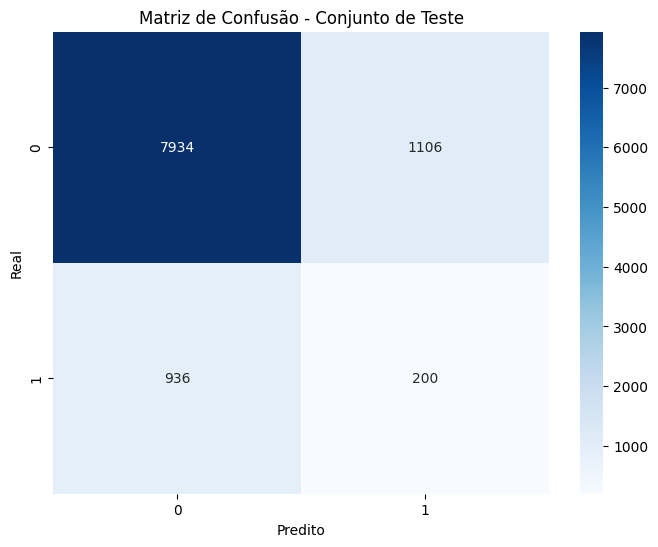

In [60]:
# Visualizações Adicionais
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
plt.title("Matriz de Confusão - Conjunto de Teste")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

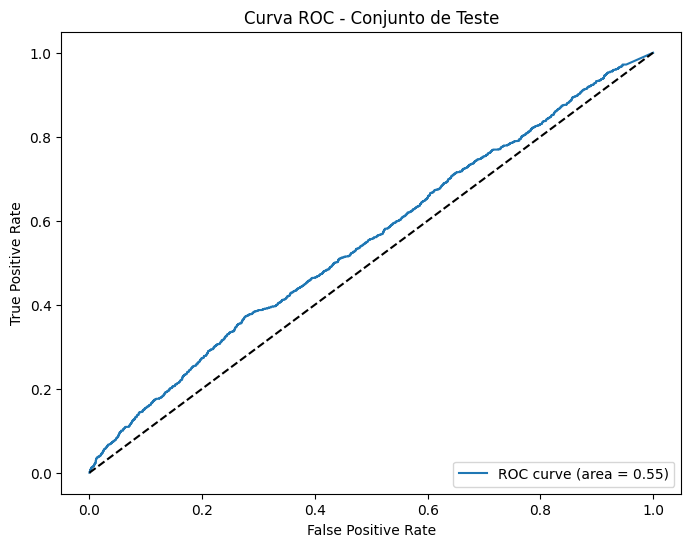

In [61]:
# Curva ROC
if roc_auc_test is not None and len(np.unique(y_test)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Conjunto de Teste')
    plt.legend(loc='lower right')
    plt.show()
elif roc_auc_test is not None:
    print("Curva ROC para problemas multiclasse não está implementada neste código.")


In [62]:
# Comparação dos Modelos
# Já temos o DataFrame results_df com as métricas dos modelos
print(results_df)

                                Modelo  Acurácia  F1-Score    Recall   ROC AUC
0                                 K-NN  0.646192  0.708403  0.646192  0.534363
1                                  LVQ  0.394398  0.477924  0.394398       NaN
2                    Árvore de Decisão  0.171794  0.151407  0.171794  0.476193
3                                  SVM  0.141130  0.085887  0.141130       NaN
4                        Random Forest  0.135725  0.076514  0.135725  0.483871
5                      Rede Neural MLP  0.162359  0.132317  0.162359  0.483828
6                              XGBoost  0.140737  0.086422  0.140737  0.482020
7                             LightGBM  0.140737  0.085946  0.140737  0.488507
8  Comitê de Redes Neurais Artificiais  0.157150  0.118524  0.157150  0.480793
9        Comitê Heterogêneo (Stacking)  0.155676  0.117353  0.155676  0.482963


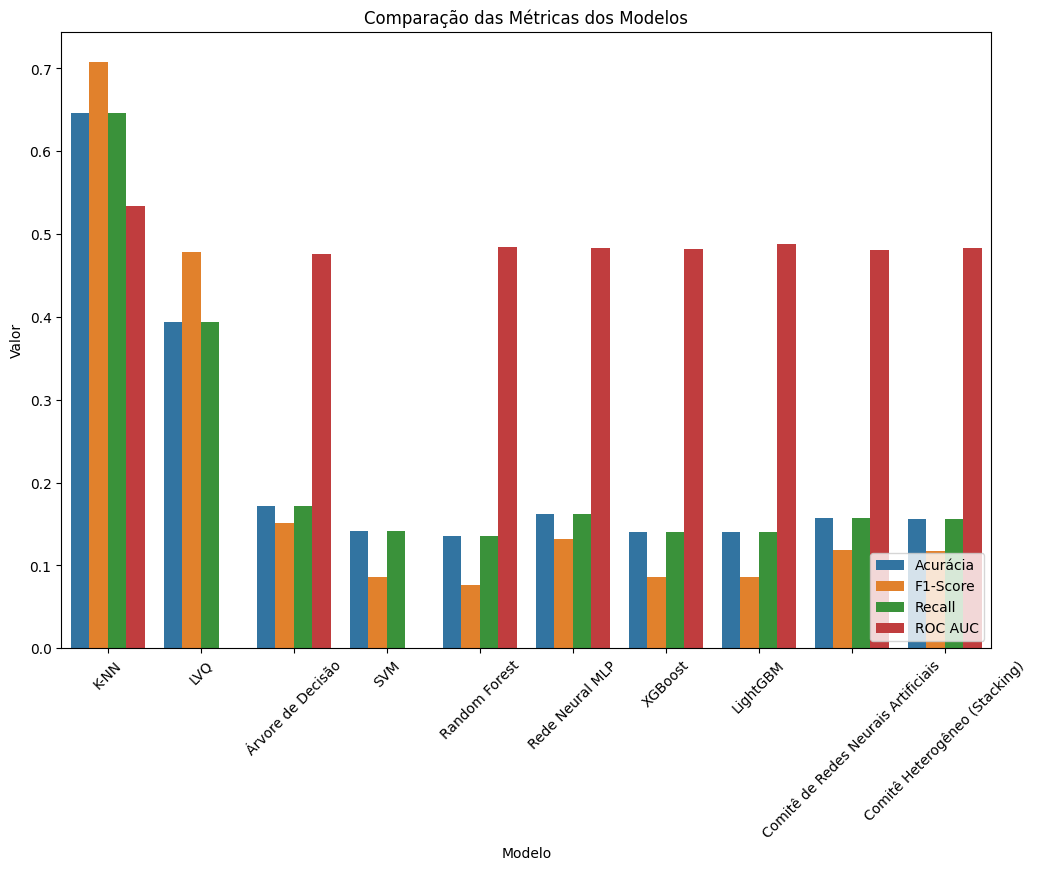

In [63]:
# Plotando as métricas
results_df_melted = results_df.melt(id_vars='Modelo', value_vars=['Acurácia', 'F1-Score', 'Recall', 'ROC AUC'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12,8))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=results_df_melted)
plt.xticks(rotation=45)
plt.title('Comparação das Métricas dos Modelos')
plt.legend(loc='lower right')
plt.show()

In [64]:
# Implementação da Metodologia de Janez Demsar
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Usando os scores de cross-validation armazenados em cv_results
scores_df = pd.DataFrame(cv_results)

# Teste de Friedman
stat, p = friedmanchisquare(*[scores_df[model] for model in scores_df.columns])
print(f'Estatística: {stat}, p-valor: {p}')

# Se p-valor < 0.05, há diferença significativa
if p < 0.05:
    print('Diferença significativa entre os modelos. Realizando teste de Nemenyi.')
    nemenyi = sp.posthoc_nemenyi_friedman(scores_df)
    print(nemenyi)
else:
    print('Não há diferença significativa entre os modelos.')

Estatística: 81.51334951456313, p-valor: 8.083737359187218e-14
Diferença significativa entre os modelos. Realizando teste de Nemenyi.
                                             K-NN           LVQ  \
K-NN                                 1.000000e+00  9.992608e-01   
LVQ                                  9.992608e-01  1.000000e+00   
Árvore de Decisão                    9.014659e-01  9.992608e-01   
SVM                                  2.838903e-04  6.394110e-03   
Random Forest                        1.468623e-01  5.768656e-01   
Rede Neural MLP                      1.455492e-03  2.382537e-02   
XGBoost                              3.817934e-06  1.688971e-04   
LightGBM                             2.215821e-09  2.416780e-07   
Comitê de Redes Neurais Artificiais  5.749325e-05  1.699687e-03   
Comitê Heterogêneo (Stacking)        1.221074e-01  5.239372e-01   

                                     Árvore de Decisão       SVM  \
K-NN                                          0.901466  0.00